# TFM. Deep Visin applied to Real state.

- Tensorflow-GPU on Colab => https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=oM_8ELnJq_wd
- Why using GPU for Deep Learning => https://towardsdatascience.com/what-is-a-gpu-and-do-you-need-one-in-deep-learning-718b9597aa0d


Developer stuff:
- https://github.com/users/albertovpd/projects/8
- https://github.com/albertovpd/viu-fundamentos_redes_neuronales/tree/main/colabs/tasks
- https://github.com/albertovpd/viu-fundamentos_redes_neuronales/blob/main/colabs/clase_2y3-Introduccion_a_Deep_Learning_Colab_ipynb.ipynb

- https://analyticsindiamag.com/transfer-learning-for-multi-class-image-classification-using-deep-convolutional-neural-network/
- https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
- https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e
- https://www.kaggle.com/ryanholbrook/overfitting-and-underfitting


In [1]:
# google stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libraries

In [47]:
%tensorflow_version 2.x
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# architecture 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Model

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# optimization
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.regularizers import l1_l2, l2

# pre-trained models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50

import os
import pickle
import tarfile

# counting classes with library
from collections import Counter

# viz & arrays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline



- base directory

In [4]:
!ls "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"

AlbertoVargas-sistema_clasificacion_viviendas_imagenes.gslides	output
input								src


In [5]:
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
input_folder = base_folder+"input/"
src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

- functions

In [6]:
def freezing_layers(model, block: str):
  '''
  for transfer-learning
  it freezes all layers until the selected block
  '''
  for layer in model.layers:
    if layer.name == block:
      break

    layer.trainable = False
    print("layer " + layer.name + " frozen")

# load pickling data allocated in Drive

In [7]:
with open(input_folder+"pickle_all_images_df.pickle", "rb") as input_file:
    data_x = pickle.load(input_file)
with open(input_folder+"pickle_all_classes.pickle", "rb") as input_file:
    data_y = pickle.load(input_file)

- some preview

In [8]:
print(Counter(data_y))

Counter({'Livingroom': 1273, 'Bedroom': 1248, 'Dinning': 1158, 'Kitchen': 965, 'Bathroom': 606})


In [9]:
classes_list = list(Counter(data_y).keys())

- i'll have to deal with this unbalanced classes later. 
- let's begin with the simplest stuff first

In [10]:
print("pics shape: ",data_x.shape,
      "\nnumber of classes: ", len(set(data_y))
      )

pics shape:  (5250, 128, 128, 3) 
number of classes:  5


Dinning


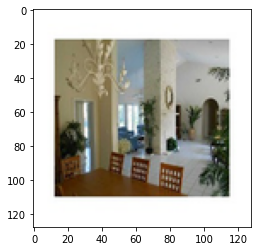

In [11]:
# showing some stuff 
print(data_y[42])
imgplot = plt.imshow(data_x[42])
plt.show()

- we have to transform y-label into numeric

In [12]:
# transforming labels into numeric
y = np.unique(data_y)
mapping = { key : value for key,value in zip(y,range(len(y)))}
data_y_num = np.array([mapping[i] for i in data_y])

In [13]:
#train_ratio = 0.7
#validation_ratio = 0.15
#test_ratio = 0.15

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y_num, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5) 
allx= len(data_x)
print(round(len(x_train)/allx,2), round(len(x_val)/allx,2), round(len(x_test)/allx,2))
del data_y
del data_x

#One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

0.7 0.15 0.15


In [14]:
print("train:  ", x_train.shape, y_train.shape,
      "\ntest: ", x_test.shape,y_test.shape,
      "\nval:  ", x_val.shape, y_val.shape)

train:   (3675, 128, 128, 3) (3675, 5) 
test:  (788, 128, 128, 3) (788, 5) 
val:   (787, 128, 128, 3) (787, 5)


---------------------------------------------------
---------------------------------------------------


# Step 1. Pretrained NN performance.

- Basic NN start:
    - Alexnet
    - ResNet
    - SqueezeNet
    - EfficientNet
    - any other I think it could be great
    - vgg19

    -----------------------------------------------
    

## VGG19

In [15]:
#Data Augmentation first
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True, zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [16]:
#Defining the VGG Convolutional Neural Net
base_model_vgg = VGG19(include_top = False, weights = 'imagenet', input_shape = (128, 128, 3), classes = y_train.shape[1])
base_model_vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [17]:
#freezing_layers(base_model_vgg,'block5_conv1')

In [18]:
base_model_vgg.trainable = False  
#Adding the final layers to the above base models where the actual classification is done in the dense layers
pre_trained_vgg= Sequential()
pre_trained_vgg.add(base_model_vgg) # adding pre-trained model
pre_trained_vgg.add(Flatten()) 
#Adding the Dense layers along with activation and batch normalization
pre_trained_vgg.add(Dense(1024,activation=('relu'),input_dim=512))
pre_trained_vgg.add(Dense(512,activation=('relu'))) 
pre_trained_vgg.add(Dense(256,activation=('relu'))) 
pre_trained_vgg.add(Dropout(.3))
pre_trained_vgg.add(Dense(128,activation=('relu')))
pre_trained_vgg.add(Dropout(.2))
pre_trained_vgg.add(Dense(5,activation=('softmax'))) 

#Checking the final model summary
pre_trained_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

### analytics india

In [19]:
#Learning Rate Annealer - decreases the learning rate after a certain number of epochs if the error rate does not change. Here, through this technique, 
# we will monitor the validation accuracy and if it seems to be a plateau in 3 epochs, it will reduce the learning rate by 0.01.
from keras.callbacks import ReduceLROnPlateau

lrr= ReduceLROnPlateau(monitor='accuracy', factor=.01, patience=3, min_lr=1e-5) # "val_acc " warning


In [20]:
#Initializing the hyperparameters
from tensorflow.keras.optimizers import SGD, Adam
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# crossentroty: logaritmic metric from 0.99 (terrible) to 0 (too much perfect)=> https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/
pre_trained_vgg.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
#Training the model - al usar esta config no tengo un array de val_accuracy, val_loss https://stackoverflow.com/questions/55746382/why-val-loss-and-val-acc-are-not-displaying
vgg19_pre = pre_trained_vgg.fit_generator(
    train_generator.flow(x_train, y_train, batch_size= batch_size),
    epochs = epochs, 
    validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), 
    steps_per_epoch = len(x_train)//batch_size , # to avoid running out of data error
    validation_steps  = len(x_test)//batch_size, # to avoid running out of data error
    callbacks=[lrr], 
    verbose = 1
    )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
28/28 [==============================] - 16s 588ms/step - loss: 0.0575 - accuracy: 0.9828 - val_loss: 1.4313 - val_accuracy: 0.6914
Epoch 2/50
28/28 [==============================] - 16s 568ms/step - loss: 0.0591 - accuracy: 0.9822 - val_loss: 1.3357 - val_accuracy: 0.7005
Epoch 3/50
28/28 [==============================] - 16s 575ms/step - loss: 0.0536 - accuracy: 0.9831 - val_loss: 1.3518 - val_accuracy: 0.6888
Epoch 4/50
28/28 [==============================] - 16s 575ms/step - loss: 0.0582 - accuracy: 0.9834 - val_loss: 1.4315 - val_accuracy: 0.6901
Epoch 5/50
28/28 [==============================] - 16s 571ms/step - loss: 0.0464 - accuracy: 0.9859 - val_loss: 1.3313 - val_accuracy: 0.6914
Epoch 6/50
28/28 [==============================] - 16s 580ms/step - loss: 0.0582 - accuracy: 0.9834 - val_loss: 1.3834 - val_accuracy: 0.7018
Epoch 7/50
28/28 [==============================] - 16s 587ms/step - loss: 0.0532 - accuracy: 0.9859 - val_loss: 1.3130 - val_accuracy: 0.6992

In [ ]:
!ls output_folder 

In [60]:
#save model
pre_trained_vgg.save(output_folder+"deepCNN_vgg19_1.h5")

Text(0, 0.5, 'Loss/Accuracy')

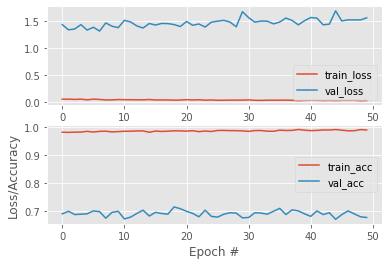

In [37]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(np.arange(0, epochs), vgg19_pre.history["loss"], label="train_loss")
ax[0].plot(np.arange(0, epochs), vgg19_pre.history["val_loss"], label="val_loss")
ax[0].legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
#Accuracy
ax[1].plot(np.arange(0, epochs), vgg19_pre.history["accuracy"], label="train_acc")
ax[1].plot(np.arange(0, epochs), vgg19_pre.history["val_accuracy"], label="val_acc")
ax[1].legend()
#plt.legend()
#plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

In [49]:
#Evaluatin
print("[INFO]: Model godness...")
y_pred = pre_trained_vgg.predict(x_test, batch_size=128)
y_true=np.argmax(y_test,axis=1)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names = classes_list ))

[INFO]: Model godness...
              precision    recall  f1-score   support

     Dinning       0.76      0.68      0.72        88
     Bedroom       0.76      0.78      0.77       178
  Livingroom       0.64      0.67      0.65       182
     Kitchen       0.62      0.65      0.63       141
    Bathroom       0.60      0.57      0.58       199

    accuracy                           0.66       788
   macro avg       0.67      0.67      0.67       788
weighted avg       0.67      0.66      0.66       788

